In [241]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import community

import random
import math

import cmocean as cmo



%matplotlib inline

# Data Section

## Data acquired:
Occupation transition data between 2016 and 2017

## Data required:
Employment levels for each occupation at the start of the simulation  
Swedish beveridge curve for a certain number of years (aggregate)


In [221]:
# This is where the occupation transition data (as well as occupation code keys) is imported

data = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/swedish_occupation_transitions.csv', sep = ';', index_col = 0)
del data.index.name
data = data.drop(axis = 1, labels = 'Totalsumma')
data = data.drop(axis = 1, index = 'Totalsumma')
last = data.index[-1]
data = data.rename(index={last: 'NULL'})

# with open('/Users/lh/MSc_Thesis/Data_Labour/Ssyk-2012-koder.csv', mode='r') as infile:
#     reader = csv.reader(infile)
#     with open('/Users/lh/MSc_Thesis/Data_Labour/Ssyk-2012-koder_new.csv', mode='w') as outfile:
#         writer = csv.writer(outfile)
#         SSYK_dict = {rows[0]:rows[1] for rows in reader}

In [222]:
# This section calculates the adjacency matrix A from the raw data

A = pd.DataFrame(np.zeros(data.shape), columns = data.columns, index = data.index)

for i in range(data.shape[0]):
    total = 0
    for t in range(data.shape[1]):
        if math.isnan(data.iloc[i,t]) != True:
            total += data.iloc[i,t]
        else:
            data.iloc[i, t] = 0

    for j in range(data.shape[1]):
        T = data.iloc[i,j]
        A.iloc[i,j] = (T/total)

A.index = A.index.map(str)
A.columns = A.columns.map(str)

In [223]:
# This sets up the visualization of the network
## The size of the nodes is proportional to the amount of workers who stayed in their proffesion between 2016 and 2017

def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    Used here to adjust the size of the nodes
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    return A/np.sum(A)

# Create the graph G from the adjeceny matrix
G = nx.from_pandas_adjacency(A, create_using = nx.DiGraph)

# List of all the occupation codes
occupations = list(G.nodes)

# Dictionaries holding the first and second levels of the SSYK code respectively
first_level = {name:name[0] for name in occupations}
second_level = {name:name[0:1] for name in occupations}

# The amount of workers who stayed in their proffession
remain_workers = np.diag(data)

# Make it into a dict 
remain_dict = dict(zip(list(G.nodes), remain_workers))

# Calculate the size of each node
ns = softmax(0.7*np.log2(1000+np.array(list(remain_dict.values()))))*15000

# Give the network the attributes used for visualisation
nx.set_node_attributes(G, first_level, 'SSYK1')
nx.set_node_attributes(G, second_level, 'SSYK2')
nx.set_node_attributes(G, remain_dict, 'remained_workers')

# Ten colors used for visualisation
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e", "#c36a7c"]

# Get all the unique first level codes
vals = list(set(val for val in first_level.values()))

# Make a dict that stores the color each node should get based on their first level
col_dict = {}
for i in range(len(vals)):
    col_dict[vals[i]] = cols[i]

# Make a list that contains the color of every node
col_list = []
for val in first_level.values():
    col_list.append(col_dict[val])

# Make a list that contains the weight for each link
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = softmax(0.7*np.log2(1000+np.array(weights)))*1500



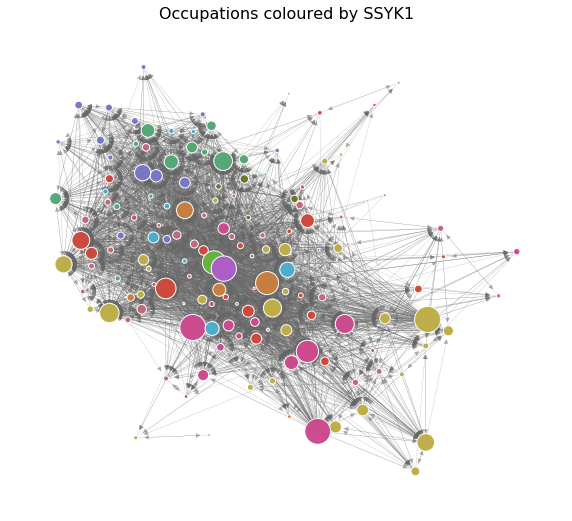

In [116]:
# This section visualises the network where nodes are colored by their first level code and the size correspond to the number of workers 
# who stayed in their proffession
fig, ax = plt.subplots(1,1,figsize=(10,9))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, with_labels = True, node_color=col_list, node_size = ns, alpha=0.99, edgecolors='w', ax = ax)

nx.draw_networkx_edges(G, pos, edge_color='#666666', width=weights, alpha=0.5, ax=ax)

ax.set_axis_off()

ax.set_title("Occupations coloured by SSYK1", fontsize=16)

#plt.savefig('e_coli.png', dpi=425, bbox_inches='tight')
plt.show()

In [61]:
def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    A = A/np.sum(A)

ns = softmax(remain_dict.values())
ns


TypeError: unsupported operand type(s) for *: 'dict_values' and 'float'

In [242]:
# This is where the automation shock data from Frey and Osborne is imported and processed between occupation classification systems

frey_osborne = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/osborne_frey_data.csv', sep = ';', index_col = 0)

SOC_shock = frey_osborne[['Probability', 'SOC code']]
SOC_shock.columns = ['Computerisation Probability', 'soc10']

for i in range(len(SOC_shock['soc10'])):
    SOC_shock.iloc[i,1] = SOC_shock.iloc[i,1][0:2] + SOC_shock.iloc[i,1][3:7]
    #SOC_shock.iloc[i,1] = SOC_shock.iloc[i,1]


SOC_ISCO = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/soc10_isco08.csv', sep = ',')
for i in range(len(SOC_ISCO['isco08'])):
    SOC_ISCO.iloc[i,1] = str(SOC_ISCO.iloc[i,1])
    SOC_ISCO.iloc[i,0] = str(SOC_ISCO.iloc[i,0])
    if len(SOC_ISCO.iloc[i,1]) == 3:
        SOC_ISCO.iloc[i,1] = '0' + SOC_ISCO.iloc[i,1]

ISCO_SSYK = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/nyckel_ssyk2012_isco-08.csv', sep = ';')
ISCO_SSYK = ISCO_SSYK[['SSYK 2012 kod','ISCO-08 ']]
ISCO_SSYK.columns = ['ssyk12', 'isco08']
for i in range(len(ISCO_SSYK['isco08'])):
    ISCO_SSYK.iloc[i,1] = str(ISCO_SSYK.iloc[i,1])
    ISCO_SSYK.iloc[i,0] = str(ISCO_SSYK.iloc[i,0])


# The file above contains many duplicates
ISCO_SSYK.drop_duplicates(inplace=True)


# Below transfers SOC_shock to SSYK_shock
ISCO_shock = pd.merge(SOC_shock, SOC_ISCO, on = 'soc10')

SSYK_shock = pd.merge(ISCO_shock, ISCO_SSYK, on = 'isco08')

# The codes are 4 level need to be 3 level. Only need to change final table (SSYK_shock)

SSYK_shock['ssyk3'] =  [str(code)[0:3] for code in SSYK_shock['ssyk12']]

SSYK3_shock = SSYK_shock[['Computerisation Probability', 'ssyk3']]

SSYK3_shock = SSYK3_shock.groupby(['ssyk3'], as_index=False).mean()

print(set(SOC_shock['soc10'])-set(SOC_ISCO['soc10']))



# The shock is set as an attribute in the network

SSYK3 = list(SSYK3_shock['ssyk3'])
SSYK3_fromnw = list(G.nodes)


print(list(set(SSYK3_fromnw) - set(SSYK3)))

print(SSYK_shock)

SSYK_shock.to_csv('/Users/lh/MSc_Thesis/Data_Labour/occupation_shock.csv', sep = ';')

# PRoblem is that certain SOC codes in osborne frey have been abbreviated with 0s. Which makes the matching miss a few rows
# This problem can be fixed

# SOC codes that are not found in file
# {'292037', '292055', '499799', '291060', '394831', '319799', '292799', '251000', '253999', '151179', '474799', '131078', '452090', '299799', '151150', '151799', '519399', '291111'}


{'292037', '292055', '499799', '291060', '394831', '319799', '292799', '251000', '253999', '151179', '474799', '131078', '452090', '299799', '151150', '151799', '519399', '291111'}
['***', '231', '21', 'NULL', '31', '221', '11', '222']
      Computerisation Probability   soc10 isco08 ssyk12 ssyk3
0                          0.0028  291125   2269   2271   227
1                          0.0028  291125   2269   2273   227
2                          0.0028  291125   2269   2289   228
3                          0.0035  291122   2269   2271   227
4                          0.0035  291122   2269   2273   227
...                           ...     ...    ...    ...   ...
1472                       0.9900  435011   3331   3331   333
1473                       0.9800  519111   8183   8181   818
1474                       0.9900  439021   4132   4119   411
1475                       0.9900  519151   8132   8132   813
1476                       0.9900  419041   5244   5242   524

[1477 rows x 5 colu

ImportError: cannot import name 'get_compression_method' from 'pandas.io.common' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/io/common.py)

In [169]:
# Visualisation of Frey and Osborne data

In [307]:
# Data for calibrating and setting up the model

employment_SSYK = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/employment_SSYK.csv', sep = ',')

employment_monthly = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/employment_monthly.csv', sep = '\t')
for i in range(len(employment_monthly['manad'])):
    employment_monthly.iloc[i,0] = employment_monthly.iloc[i,0][0:4] +'-'+ employment_monthly.iloc[i,0][5:7]

employment_monthly.columns = ['month', 'employed', 'employed_error']

unemployment_monthly = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/unemployment2000_2020.csv', sep = '\t')
unemployment_monthly = unemployment_monthly[["month", "total Percent", "total Margin of error percent"]]
unemployment_monthly.columns = ['month', 'unemployed', 'unemployed_error']

for i in range(len(unemployment_monthly['month'])):
    unemployment_monthly.iloc[i,0] = unemployment_monthly.iloc[i,0][0:4] +'-'+ unemployment_monthly.iloc[i,0][5:7]

vacancies_quarterly = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/vakanser2001_2019.csv', sep = '\t')
for i in range(len(vacancies_quarterly['kvartal'])):
    vacancies_quarterly.iloc[i,0] = vacancies_quarterly.iloc[i,0][0:4] +'Q'+ vacancies_quarterly.iloc[i,0][5:7]
vacancies_quarterly.columns = ['quarter', 'vacancies', 'vacancies_error']

vacancies_quarterly.set_index(pd.PeriodIndex(np.array(vacancies_quarterly['quarter']), freq='Q'), inplace = True)
vacancies_quarterly = vacancies_quarterly[['vacancies', 'vacancies_error']]



# vacancy_rate = vacancies/(employment + vacancies)


employment_quarterly = employment_monthly[['month','employed', 'employed_error']].groupby(pd.PeriodIndex(np.array(employment_monthly['month']), freq='Q'), axis=0).mean()

unemployment_quarterly = unemployment_monthly[['month','unemployed', 'unemployed_error']].groupby(pd.PeriodIndex(np.array(unemployment_monthly['month']), freq='Q'), axis=0).mean()

quarterly_data = unemployment_quarterly.join(employment_quarterly)
quarterly_data = quarterly_data.join(vacancies_quarterly)
quarterly_data['vacancy_rate'] = quarterly_data['vacancies']*100/(quarterly_data['employed']*1000 + quarterly_data['vacancies'])




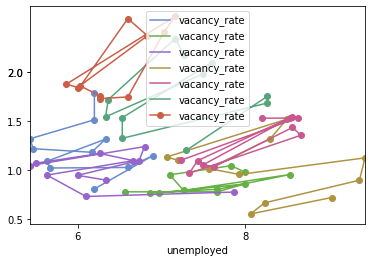

In [362]:
# Visualisation of labour market data

# plt.plot(quarterly_data['unemployed'], quarterly_data['vacancy_rate'], '-o')
# plt.text(quarterly_data['unemployed'], quarterly_data['vacancy_rate'], list(quarterly_data.index.to_series().astype(str)))
# plt.show()

fig, ax = plt.subplots()

ax.set_xticks([4,6,8,10])
ax.set_yticks([0, 0.5, 1, 1.5, 2, 2,5])
ax.set_xbound(lower = 0, upper = 10)


cut_q = [i for i in range(len(list(quarterly_data.index))) if i%11 == 0]
line_cols = ["#688bcd", "#66b046", "#9764ca", "#af943f", "#c85990", "#55a47b", "#cb5e46"]
for i in range(len(cut_q)):
    if i != len(cut_q)-1:
        quarterly_data.iloc[cut_q[i]:cut_q[i+1]].plot('unemployed', 'vacancy_rate', kind='line', ax=ax, color = line_cols[i], ls = '-', marker = 'o')
    else:
        quarterly_data.iloc[cut_q[i]:-1].plot('unemployed', 'vacancy_rate', kind='line', ax=ax, color = line_cols[i], ls = '-', marker = 'o')

plt.show()

# for k, v in quarterly_data[['unemployed','vacancy_rate']].iterrows():
#     ax.annotate(k, v)

# To do Automation Overlay
## Translate data using the keys you found
## Give nodes attribute

In [121]:
# setup network
def set_attributes(G, data):
    '''
    Initialises the node attributes of the occupational mobility network.
    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    data (?): Data used to specify attribute values
    
    setting up data will have the following form:
    data (pd.DataFrame): Columns contain values for the attributes and rows are occupations

    The attributes are:
    employed (int): Number of employees in the occupation
    unemplyed (int): Number of unemployed in the occupation
    vacancies (int): Number of vacancies in the occupation
    applications (list): List where the elements are the name of the occupation where the application is coming from
    target_demand (int): The target demand of the occupation (exogenous and used for automation shock)
    risk_factor (float): A value between 0 and 1 indicating the risk of a proffession (could be automation or corona or whatever)

    Note that the current demand is implicit (=employed + vacancies)
    '''
    # Make dictionaries
    attributes = data.to_dict()

    # Add some variables
    # attributes['target_demand']
    
    # Set attrbutes
    for key, value in attributes.items():

        nx.set_node_attributes(G, value, str(key))

def make_vacancies(G, delta_ny, gamma_ny):
    '''
    Each occupation has a probability of making vacancies each time step that depends on the difference between
    current demand and target demand as well as an exogenous probability 

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    other parameters
    '''
    # The attributes we need to calculate new vacancies
    vac_dict = nx.get_node_attributes(G, 'vacancies')
    emp_dict = nx.get_node_attributes(G, 'employed')
    td_dict = nx.get_node_attributes(G, 'target_demand')

    # loop through all the occupations and create vacancies as described in the paper
    for occupation, vacancies in vac_dict.items():
        # The occupation specificattribute values
        target_demand = td_dict[occupation]
        employed = emp_dict[occupation]
        current_demand = vacancies + employed

        # Calculate the probability of creating new vacancies (equation 10)
        demand_diff = max(0, current_demand - target_demand)
        alpha_ny = gamma_ny*demand_diff/employed
        p_ny = delta_ny + alpha_ny - delta_ny*alpha_ny

        # Expected number of new vacancies
        new_vacancies = round(p_ny*vacancies)

        # Add the new vacancies to total number of vacancies
        vac_dict[occupation] += new_vacancies
        nx.set_node_attributes(G, vac_dict, 'vacancies')


def seperate_workers(G, delta_u, gamma_u):
    '''
    Each occupation has a probability of seperating workers each time step that depends on the difference between
    current demand and target demand as well as an exogenous probability 

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    other parameters
    '''

    # The attributes we need to calculate number of seperated workers
    unemp_dict = nx.get_node_attributes(G, 'unemployed')
    emp_dict = nx.get_node_attributes(G, 'employed')
    td_dict = nx.get_node_attributes(G, 'target_demand')

    # loop through all the occupations and seperate workers as described in the paper
    for occupation, unemployed in unemp_dict.items():
        # The occupation specificattribute values
        target_demand = td_dict[occupation]
        employed = emp_dict[occupation]
        current_demand = vacancies + employed

        # Calculate the probability of creating new vacancies (equation 9)
        demand_diff = max(0, current_demand - target_demand)
        alpha_u = gamma_u*demand_diff/employed
        # probability calculation (equation 11)
        p_u =  delta_u + alpha_u - delta_u*alpha_u

        
        separated = round(p_u*unemployed)

        unemp_dict[occupation] += separated
        nx.set_node_attributes(G, unemp_dict, 'unemployed')

def make_applications(G):
    '''
    Each unemployed worker send out an application to a neighbouring occupation proportional to the edge weight
    between the occupations

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    '''
    # loop through every occupation and every unemployed person in the occupation and add applications in the 
    # applications attribute of the occupation that the worker applies to
    app_dict = nx.get_node_attributes(G, 'applications')
    unem_dict = nx.get_node_attributes(G, 'unemployed')
    vac_dict = nx.get_node_attributes(G, 'vacancies')

    A_dict = nx.get_edge_attributes(G, 'weight')

    for occupation in app_dict:
        unemployed = unem_dict[occupation]
        neighbors = [n for n in G.neighbors(occupation)]

        # Calculate probabilities (equation 7)
        vac_A_list = [vac_dict[n]* A_dict[(occupation, n)] for n in neighbors]
        vac_A_sum = sum(vac_A_list)
        p_list = vac_A_list/vac_A_sum 

        # Each unemployed person chooses an occupation to apply to
        for _ in range(unemployed):
            # Choice is weighted by probabilities calculated above
            apply_to = np.choice(neighbors, 1, p = p_list)
            # Make the application
            app_dict[apply_to].append(occupation)
    nx.set_node_attributes(G, app_dict, 'applications')


def handle_applications(G):
    '''
    Randomly accept N applications in the application attrbute where N is the number of vacancies in the occupation

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    '''
    # The attributes we need
    app_dict = nx.get_node_attributes(G, 'applications')
    vac_dict = nx.get_node_attributes(G, 'vacancies')
    emp_dict = nx.get_node_attributes(G, 'employed')
    unemp_dict = nx.get_node_attributes(G, 'unemployed')

    # loop through all the occupations and try to accept the same number of applications as there are vacancies
    for occupation in app_dict:
        applications = app_dict[occupation]
        vacancies = vac_dict[occupation]

        filled_vacancies = 0
        for j in range(vacancies):
            if len(applications) == 0:
                # if vacancies > len(applications) not all vacancies are filled
                break
            # A random application is chosen (and removed from the list of applications)
            accepted = applications.pop(random.randrange(len(applications)))

            # Increase the amount of employed people in the occupation by the number of filled vacancies
            emp_dict[occupation] += 1

            # Decrease the amount of unemployed people in the occupations where applications were accepted from
            unemp_dict[accepted] -= 1
            # Number of filled vacancies
            filled_vacancies = j + 1
    
        # Decrease the amount of vacancies in the occupation
        vac_dict[occupation] = vacancies - filled_vacancies
        # Update the applications list
        app_dict[occupation] = applications
    
    # Update the network node attributes
    nx.set_node_attributes(G, app_dict, 'applications')
    nx.set_node_attributes(G, vac_dict, 'vacancies')
    nx.set_node_attributes(G, emp_dict, 'employed')
    nx.set_node_attributes(G, unemp_dict, 'unemployed')

def update_target_demand(G, demand_0, t, T, a):
    '''
    function that updates the target demand. Used for calibrating the the model paramters

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    demand_0 (int): Initial demand
    t (int): Timestep of simulation
    T (float): The duration of a business cycle
    a (float): the amplitude of the business cycle sin wave
    '''

    target_demand = {}
    for node in G.nodes():
        target_demand[node] = demand_0[node] + a*sin(t/(2*pi*T))

    nx.set_node_attributes(G, target_demand, 'target_demand')


def shock(G, demand_0, final_demand, t, t_0, k):
    '''
    function that implements the labour demand shock

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    demand_0 (int): Initial demand
    t (int): Timestep of simulation
    t_0 (int): Midpoint of shock (where sigmoid goes from exponential increase to exponential decrease)
    k (float): 

    '''

    demand_shock = {}
    target_demand = {}

    for key in employed.keys():
        demand_shock[key] = (final_demand[key] - demand_0[key])/(1 + exp(k(t-t_0)))
        target_demand[key] = demand_0[key] + demand_shock[key]

    nx.set_node_attributes(G, target_demand, 'target demand')


def calibration_calculation(empirical_data, model_data):
    '''
    This is the function to be minimised during calibration.abs

    Parameters:
    empirical_data (dict): timeseries of vacancies and unemployment
    model_data (dict): timeseries of vacancies and unemployment
    '''

    vacancies_e = empirical_data['vacancies']
    unemployed_e = empirical_data['unemployed']

    vacancies_m = model_data['vacancies']
    unemployed_m = model_data['unemployed']

    A_e = np.trapz(vacancies_e, unemployed_e)
    A_m = np.trapz(vacancies_m, unemployed_m)

    intersection = min(A_e, A_m)
    union = max(A_e, A_m)

    return intersection/union


def simulation(G, data, years, timestep, delta_u, gamma_u, delta_ny, gamma_ny, empirical_data, t_0, k, L, avg_hours_0, a, T):
    '''
    Set attribute data of occupational mobility netowrk and carry out the simulation for a specified number of timesteps

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    data (pd.DataFrame): DataFrame containing data
    years (int): Number of years for the simulation
    timestep (float): size of each timestep in terms of weeks
    delta_u (float): probability of spontanous seperation
    delta_ny (float): probability of spontanously opneing vacancy
    gamma_u (float): speed of unemployed adjustment towards target demand
    gamma_ny (float): speed of vacancy adjustment towards target demand
    '''

    set_attributes(G, data)

    timesteps = round(years*52/timestep)

    vacancies = nx.get_node_attributes(G, 'vacancies')
    employed = nx.get_node_attributes(G, 'employed')

    for key in vacancies.keys():
        demand_0[key] = vacancies[key] + employed[key] 

    vac_data = [vacancies]
    emp_data = [employed]
    unemp_data = [nx.get_node_attributes(G, 'unemployed')]

    # Variables to calculate the post shock demand
    risk_factor = nx.get_node_attributes(G, 'risk_factor')
    average_hours_worked_0 = avg_hours_0
    employed = nx.get_node_attributes(G, 'employed')

    final_hours_worked = {}

    for occupation in risk_factor.keys():
        final_hours_worked[occupation] = average_hours_worked_0*employed[occupation]*(1-risk_factor[occupation])

    final_average_hours_worked = sum(final_hours_worked.values())/L

    # Post shock demand
    final_demand = {occupation:hours/final_average_hours_worked for occupation, hours in final_hours_worked.items()}

    for t in range(timesteps):
        handle_applications(G)
        make_applications(G)
        seperate_workers(G, delta_u, gamma_u)
        make_vacancies(G, delta_ny, gamma_ny)

        # order should be checked and changed
        if t > shock_start:
            shock(G, demand_0, final_demand, t, t_0, k)

        vac_data.append(nx.get_node_attributes(G, 'vacancies'))
        unemp_data.append(nx.get_node_attributes(G, 'unemployed'))
        emp_data.append(nx.get_node_attributes(G, 'employed'))

        update_target_demand(G, demand_0, t, T, a)

    model_data = {'vacancies': vac_data, 'unemployment': unemp_data}

    cost = calibration_calculation(empirical_data, model_data)

    vac_data = pd.DataFrame(vac_data)
    unemp_data = pd.DataFrame(unemp_data)
    emp_data = pd.DataFrame(emp_data)

    return {'vacancy data': vac_data, 'unemployment data': unemp_data, 'employment data': emp_data, 'cost': cost}




In [ ]:
# Plot results!

In [123]:
G = nx.complete_graph(3)

att_names = ['employed', 'unemployed', 'vacancies', 'applications', 'target demand']

emp_data = [2,4,6]
unemp_data = [1,2,3]
vac_data = [1,1,0]
app_data = [[], [], []]
target_demand = [2,4,6]


data = np.array([emp_data, unemp_data, vac_data, app_data, target_demand])

data = pd.DataFrame(data.T, columns = att_names)

# set_attributes(G, data)

# print('Testing make_vacancies: ')
# for _ in range(2):
#     make_vacancies(G)
# print(nx.get_node_attributes(G, 'vacancies'))

# print('Testing seperate_workers: ')
# for _ in range(2):
#     seperate_workers(G)
# print(nx.get_node_attributes(G, 'unemployed'))

# print('Testing make_applications')

# make_applications(G)
# print(nx.get_node_attributes(G, 'applications'))

# print('Testing handle_applications: ')
# handle_applications(G)
# print(G.nodes(data = True))

#simulation(G, data, 10)
print(G.nodes())

[0, 1, 2]
